In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

In [28]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [29]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [30]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'O'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(df.totalcharges.mean())

df.churn = (df.churn == 'yes').astype(int)

In [31]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [32]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [33]:
dv = DictVectorizer(sparse=False)

dict_train = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(dict_train)

dict_val = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(dict_val)

In [34]:
model = LogisticRegression(solver='newton-cg')
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8041163946061036

#Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [35]:
len(y_val)

1409

In [36]:
(y_val == churn_decision).mean()

0.8041163946061036

In [37]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [38]:
scores = []

for t in thresholds:
    score = accuracy_score(y_val, (y_pred >= t))
    print(t.round(2), score.round(3))
    scores.append(score)

0.0 0.274
0.05 0.513
0.1 0.605
0.15 0.658
0.2 0.703
0.25 0.734
0.3 0.758
0.35 0.766
0.4 0.781
0.45 0.791
0.5 0.804
0.55 0.802
0.6 0.796
0.65 0.789
0.7 0.766
0.75 0.742
0.8 0.73
0.85 0.726
0.9 0.726
0.95 0.726
1.0 0.726


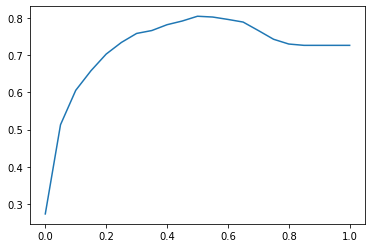

In [39]:
plt.plot(thresholds, scores)

In [40]:
from collections import Counter

In [41]:
Counter(y_pred >= 1)

Counter({False: 1409})

In [42]:
1 - y_val.mean()

0.7260468417317246

#Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

In [43]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [44]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [45]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [46]:
confusion_matrix = np.array([
    [tp, fn],
    [fp, tn]
])
confusion_matrix

array([[212, 174],
       [102, 921]])

In [47]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.15, 0.12],
       [0.07, 0.65]])

#Precision and Recall

In [48]:
p = tp / (tp + fp)
p

0.6751592356687898

In [49]:
r = tp / (tp + fn)
r

0.5492227979274611

# ROC Curves

##TPR and FPR

In [50]:
tpr = tp / (tp + fn)
tpr

0.5492227979274611

In [51]:
fpr = fp / (fp + tn)
fpr

0.09970674486803519

In [52]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, tn, fn))

In [54]:
columns = ['thresholds', 'tp', 'fp', 'tn', 'fn']

df_scores = pd.DataFrame(scores, columns = columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

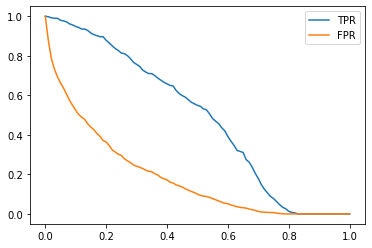

In [56]:
plt.plot(df_scores.thresholds, df_scores.tpr, label='TPR')
plt.plot(df_scores.thresholds, df_scores.fpr, label='FPR')
plt.legend()

##Random model

In [57]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [58]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [59]:
def tpr_fpr_thresholds(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, tn, fn))
    
        columns = ['thresholds', 'tp', 'fp', 'tn', 'fn']

    df_scores = pd.DataFrame(scores, columns = columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [60]:
df_rand = tpr_fpr_thresholds(y_val, y_rand)

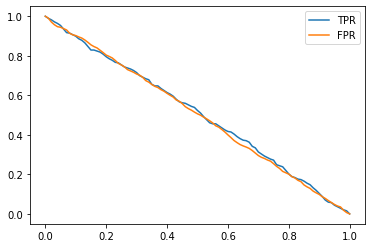

In [61]:
plt.plot(df_rand.thresholds, df_rand.tpr, label='TPR')
plt.plot(df_rand.thresholds, df_rand.fpr, label='FPR')
plt.legend()

##Ideal model

In [62]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

In [63]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [65]:
accuracy_score(y_ideal, (y_ideal_pred >= 0.726))

1.0

In [66]:
df_ideal = tpr_fpr_thresholds(y_ideal, y_ideal_pred)
df_ideal

,thresholds,tp,fp,tn,fn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,386,1008,15,0,1.000000,0.985337
2,0.02,386,994,29,0,1.000000,0.971652
3,0.03,386,980,43,0,1.000000,0.957967
4,0.04,386,966,57,0,1.000000,0.944282
...,...,...,...,...,...,...,...
96,0.96,57,0,1023,329,0.147668,0.000000
97,0.97,43,0,1023,343,0.111399,0.000000
98,0.98,29,0,1023,357,0.075130,0.000000
99,0.99,15,0,1023,371,0.038860,0.000000


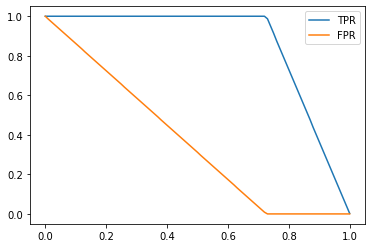

In [67]:
plt.plot(df_ideal.thresholds, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.thresholds, df_ideal.fpr, label='FPR')
plt.legend()

##Putting everything together

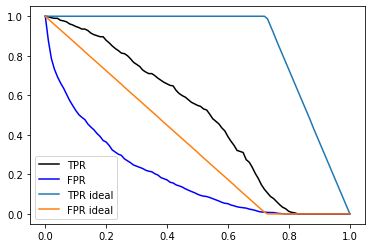

In [72]:
plt.plot(df_scores.thresholds, df_scores.tpr, label='TPR', color='black')
plt.plot(df_scores.thresholds, df_scores.fpr, label='FPR', color='blue')

#plt.plot(df_rand.thresholds, df_rand.tpr, label='TPR random', color='grey')
#plt.plot(df_rand.thresholds, df_rand.fpr, label='FPR random', color='grey')

plt.plot(df_ideal.thresholds, df_ideal.tpr, label='TPR ideal')
plt.plot(df_ideal.thresholds, df_ideal.fpr, label='FPR ideal')

plt.legend()

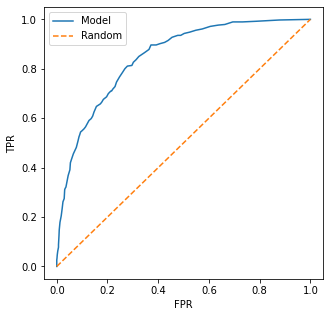

In [76]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0,1], [0,1], label='Random', linestyle='dashed')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [77]:
from sklearn.metrics import roc_curve

In [78]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

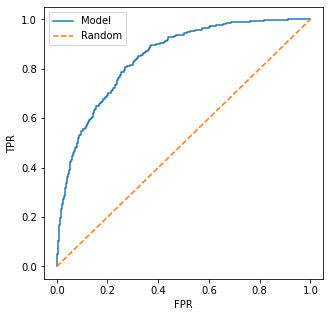

In [79]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0,1], [0,1], label='Random', linestyle='dashed')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

#ROC AUC

- Area under the ROC curve - useful metric
- Interpretation of AUC

In [80]:
from sklearn.metrics import auc

In [81]:
auc(fpr, tpr)

0.8463753361797821

In [82]:
auc(df_scores.fpr, df_scores.tpr)

0.8460461205739496

In [83]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8463753361797821

In [85]:
from sklearn.metrics import roc_auc_score

In [86]:
roc_auc_score(y_val, y_pred)

0.8463753361797821

In [87]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [94]:
n = 50000
np.random.seed(1)

neg_ind = np.random.randint(0, len(neg), size=n)
pos_ind = np.random.randint(0, len(pos), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84662

#Cross-Validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [101]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='newton-cg')
    model.fit(X_train, y_train)

    return dv, model

In [102]:
dv, model = train(df_train, y_train)

In [103]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [104]:
y_pred = predict(df_val, dv, model)

In [105]:
from sklearn.model_selection import KFold

In [111]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

print(np.mean(scores).round(5), np.std(scores).round(5))

0.84173 0.00684


In [112]:
scores

[0.8443492868412996,
 0.8449232717520859,
 0.8334095926148908,
 0.8344731246402762,
 0.8514872454582535]

In [114]:
dv, model = train(df_full_train, df_full_train.churn.values)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8583165415407281